# [ДЗ] Лекция 3
## Модели ARIMA и GARCH

# Домашнее задание
- Выберите ряд и постройте его модель ARIMA/GARCH.
- **Не обязательное дз.** Попробуйте спрогнозировать график классическим ML

In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
from arch import arch_model

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# функция проверки стационарности временного ряда
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
# построение графика
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

## ARIMA

Results of Dickey-Fuller Test:
Test Statistic                  -3.760996
p-value                          0.003333
#Lags Used                      15.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64


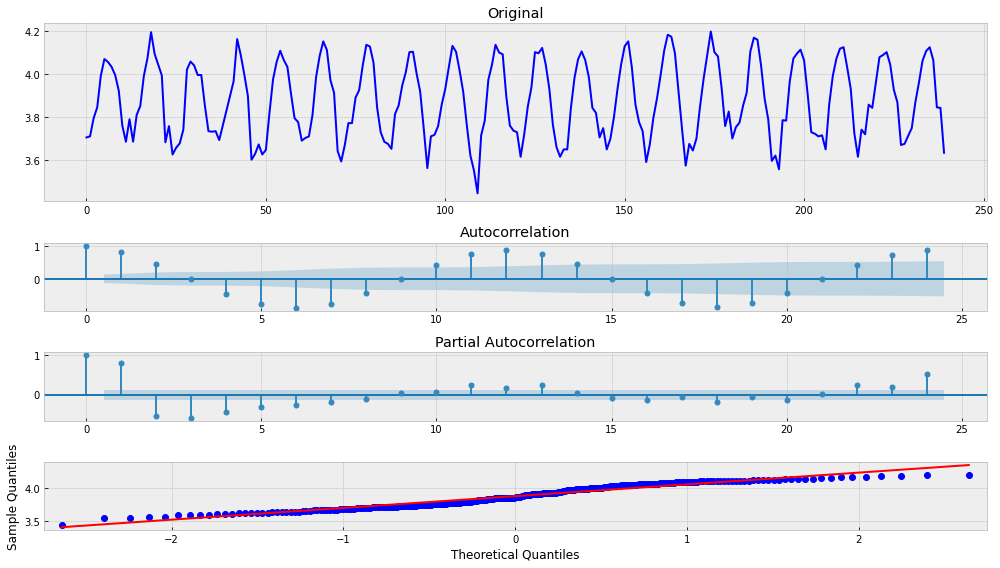

In [4]:
series = pd.read_csv("../1. Лекция/Series/mean-monthly-air-temperature-deg.csv")['Deg']
series = boxcox(series, 0)
tsplot(series)

aic: 1013.46021 | order: (0, 0, 1)
aic: 738.54274 | order: (0, 0, 2)
aic: 500.14954 | order: (0, 0, 3)
aic: 331.31390 | order: (0, 0, 4)
aic: -405.33096 | order: (0, 1, 1)
aic: -434.30041 | order: (0, 1, 2)
aic: -443.93116 | order: (0, 1, 3)
aic: -447.33661 | order: (0, 1, 4)
aic: -373.94793 | order: (0, 2, 1)
aic: -385.53047 | order: (0, 2, 2)
aic: -383.53443 | order: (0, 2, 3)
aic: -434.88784 | order: (0, 2, 4)
aic: -372.61006 | order: (1, 0, 0)
aic: -397.97589 | order: (1, 0, 1)
aic: -426.98182 | order: (1, 0, 2)
aic: -400.72366 | order: (1, 0, 3)
aic: -452.09818 | order: (1, 0, 4)
aic: -420.50185 | order: (1, 1, 0)
aic: -382.94347 | order: (1, 2, 0)
aic: -412.70196 | order: (1, 2, 2)
aic: -413.21381 | order: (2, 0, 0)
aic: -426.79839 | order: (2, 1, 0)
aic: -693.26129 | order: (2, 1, 3)
aic: -702.92245 | order: (2, 1, 4)
aic: -381.18724 | order: (2, 2, 0)
aic: -419.59221 | order: (3, 0, 0)
aic: -662.92930 | order: (3, 0, 3)
aic: -658.83571 | order: (3, 0, 4)
aic: -439.58581 | order

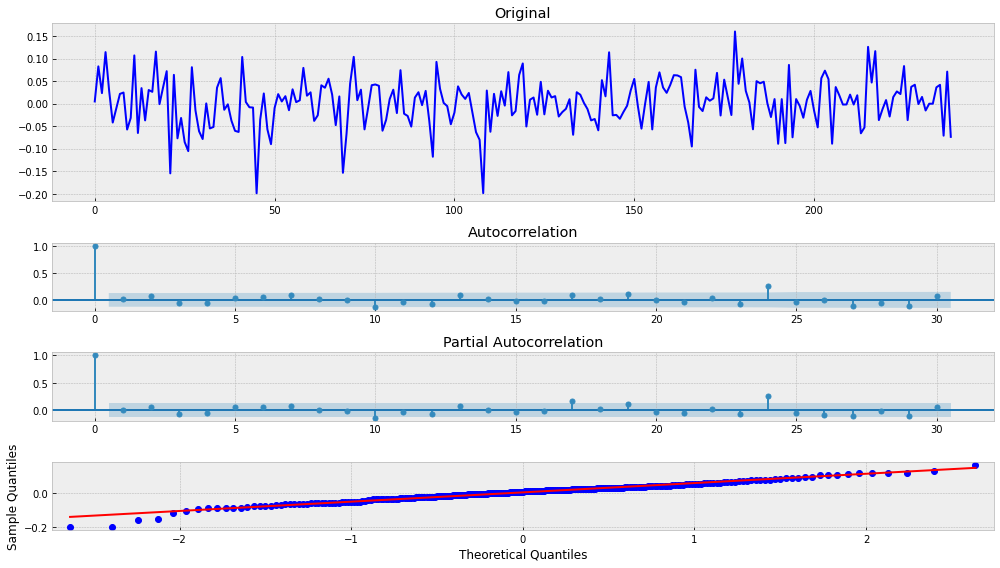

In [5]:
# определение парметров для получения оптимальных значений AIC
def get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    print('aic: {:6.5f} | order: {}'.format(tmp_aic, (i, d, j)))
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('BEST aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order, best_mdl


aic, order, mdl = get_best_model(series)
tsplot(mdl.resid, lags=30)

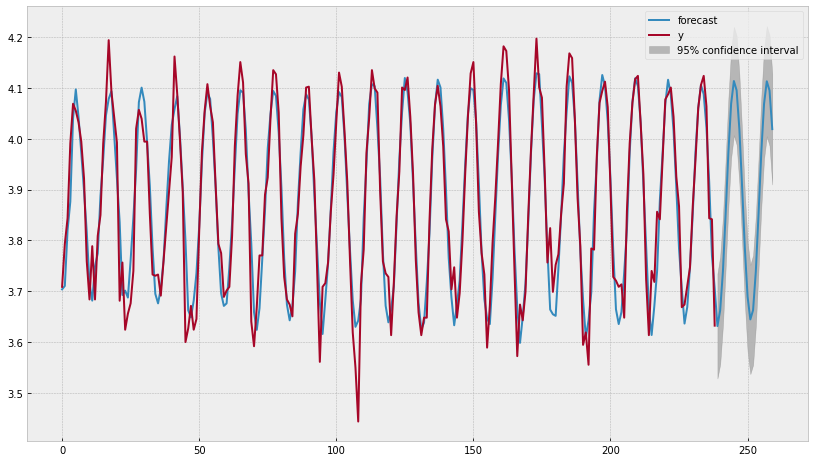

In [6]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    mdl.plot_predict(1, len(series)+20, ax=ax)
    plt.legend()
    plt.show()

## GARCH

In [7]:
series = series[12:] - series[:-12]
series = series[1:] - series[:-1]

In [8]:
am = arch_model(series)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     34,   Neg. LLF: -205.6607459096901
Iteration:     10,   Func. Count:     61,   Neg. LLF: -208.4293680186953
Optimization terminated successfully    (Exit mode 0)
            Current function value: -208.42936801870803
            Iterations: 10
            Function evaluations: 61
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                208.429
Distribution:                  Normal   AIC:                          -408.859
Method:            Maximum Likelihood   BIC:                          -395.159
                                        No. Observations:                  227
Date:                Wed, Mar 03 2021   Df Residuals:                      226
Time:      

In [9]:
p_, o_, q_ = order

# Using student T distribution usually provides better fit
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                209.519
Distribution:      Standardized Student's t   AIC:                          -399.037
Method:                  Maximum Likelihood   BIC:                          -364.788
                                              No. Observations:                  227
Date:                      Wed, Mar 03 2021   Df Residuals:                      226
Time:                              19:53:17   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

Results of Dickey-Fuller Test:
Test Statistic                -7.999033e+00
p-value                        2.361164e-12
#Lags Used                     1.500000e+01
Number of Observations Used    2.110000e+02
Critical Value (1%)           -3.461727e+00
Critical Value (5%)           -2.875337e+00
Critical Value (10%)          -2.574124e+00
dtype: float64


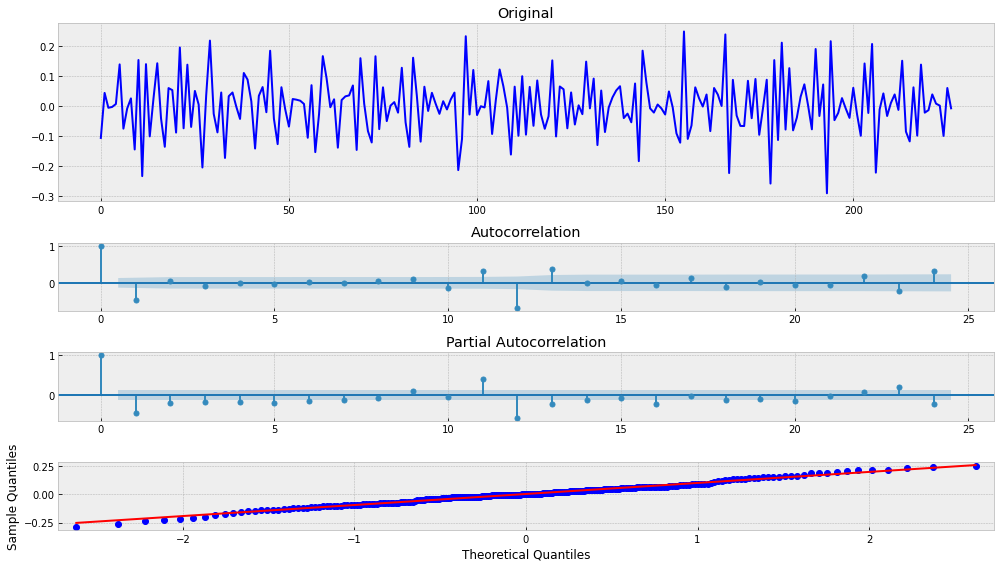

In [10]:
tsplot(res.resid)

## Полезная информация
- https://people.duke.edu/~rnau/411home.htm
- https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-276
- http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016